# Comparison with Satellite Laser Ranging (SLR) TWSA

In this notebook, we compare our TWS reconstruction to a TWS product from IGG Bonn which combines gravity field measurements of SLR and DORIS.

In [10]:
import string

import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR, repeat_by_weight

In [11]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [12]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [13]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"
slr_store = ROOT_DIR / "data/processed/igg-slr-hybrid-2.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
slr = xr.open_zarr(slr_store)
recs = xr.open_zarr(recs_store)
our = xr.open_zarr(our_store).twsa.rename("twsa_our")


In [14]:
# Resample SLR data set from 1° to 0.5°
step = 0.5
lat_05 = np.arange(89.75, -89.75 - step, -step)
lon_05 = np.arange(-179.75, 179.75 + step, step)
slr = slr.interp(lat=lat_05, lon=lon_05, method="nearest")

In [15]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, slr, recs, our])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [16]:
vars_verbose = {
    "twsa_our": "DeepRec\n(Ours)",
    "twsa_gap": "WGHM",
    "palazzoli_jpl_full": "Palazzoli's\nJPL Rec",
    "humphrey_gsfc_detrend": "Humphrey's\nGSFC Rec",
    "li_csr_full": "Li's\nCSR Rec",
    "yin_csr_full": "Yin's\nCSR Rec",
    "twsa_csr": "CSR\n(GRACE)",
}
eval_names = vars_verbose.keys()


In [17]:
grace_name = "twsa_csr"
our_name = "twsa_our"
# slr_name = "twsa_slr_gauss"
slr_name = "twsa_slr_2024"


Remove time steps not available in the evaluation product:

In [18]:
ds_slrtime = ds_all[[*eval_names, slr_name]].where(slr.time, drop=True).compute()

[########################################] | 100% Completed | 10.75 s
[########################################] | 100% Completed | 10.86 s


Calculate basin averages:

In [19]:
# Dims: ("model", "region")
ds_basin = (
    # Basins over 200,000 km²
    ds_slrtime.chunk(lat=-1, lon=-1, time=10)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
).compute()
ds_basin


[########################################] | 100% Completed | 277.16 s
[########################################] | 100% Completed | 276.82 s


<xarray.Dataset> Size: 1MB
Dimensions:                (time: 252, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 1995-01-01 ... 2015-12-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    twsa_our               (region, time) float64 145kB -14.01 17.48 ... -38.9
    twsa_gap               (region, time) float64 145kB 18.66 56.66 ... 37.66
    palazzoli_jpl_full     (region, time) float64 145kB 7.447 47.01 ... -65.58
    humphrey_gsfc_detrend  (region, time) float64 145kB -30.14 27.02 ... -90.61
    li_csr_full            (region, time) float64 145kB -65.78 9.697 ... -48.93
    yin_csr_full           (region, time) float64 145kB -21.15 35.06 ... -38.48
    twsa_csr               (region, time) float64 145kB nan nan nan ... nan nan
    twsa_slr_2024          (region, time) float64 145kB 2.271 25.5 ... -18.64

Split into Pre-GRACE and GRACE periods:

In [20]:
ds_basin_pre = ds_basin.drop_vars(grace_name).sel(time=slice(None, "2001"))
ds_basin_post = ds_basin.sel(time=slice("2002", None))
# Drop time stamps which are not available for at least one variable
ds_basin_pre = ds_basin_pre.where(ds_basin_pre.dr.time_notnull("region"), drop=True)
ds_basin_post = ds_basin_post.where(ds_basin_post.dr.time_notnull("region"), drop=True)

### Basin scale PCC

In [21]:
# Calculate PCC for pre-GRACE era
da_pcc_pre = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_pre.drop_vars(slr_name),
    ds_basin_pre[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")

# Calculate PCC for GRACE era
da_pcc_post = metrics.pearson_r(
    # Model are evaluated, SLR is the truth
    ds_basin_post.drop_vars(slr_name),
    ds_basin_post[slr_name],
    dim="time",
    skipna=True,
).to_dataarray("model")


In [22]:
# Combine along new `era` dimension
da_pcc = xr.concat([da_pcc_pre, da_pcc_post], dim=pd.Index(["pre", "post"], name="era"))


In [23]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)


In [24]:
our_pcc_pre = da_pcc_pre.sel(model="twsa_our")
our_pcc_post = da_pcc_post.sel(model="twsa_our")

In [25]:
print(f"{our_pcc_pre.min() = :.2f}")
print(f"{our_pcc_pre.max() = :.2f}\n")

print(f"{our_pcc_post.min() = :.2f}")
print(f"{our_pcc_post.max() = :.2f}\n")

our_pcc_pre.min() = -0.20
our_pcc_pre.max() = 0.94

our_pcc_post.min() = 0.17
our_pcc_post.max() = 0.98



In [26]:
print(f"{our_pcc_pre.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_pcc_pre.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")

print(f"{our_pcc_post.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_pcc_post.weighted(da_basin_areas).quantile(0.1) = :.2f}\n")


our_pcc_pre.weighted(da_basin_areas).mean() = 0.68
our_pcc_pre.weighted(da_basin_areas).quantile(0.9) = 0.90

our_pcc_post.weighted(da_basin_areas).mean() = 0.82
our_pcc_post.weighted(da_basin_areas).quantile(0.1) = 0.63



## Map plots

In [27]:
pcc_kwargs = dict(
    coastlines=True,
    gridlines=True,
    cmap=cmc.lipari_r,
    vmin=0,
    vmax=1,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True),
    add_colorbar=False,
    cbar_kwargs=None,
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.5, facecolor="None", rasterized=True, zorder=3.0
)

pcc_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66, extend="min")


In [28]:
# Create a dummy array with the dimensions (lat x lon)
da_dummy = xr.zeros_like(ds_slrtime[our_name].isel(time=0, drop=True)).rename("dummy")

In [29]:
# Get start and end years of time series
times_pre = ds_basin_pre.get_index("time")
times_post = ds_basin_post.get_index("time")

period_pre = (times_pre[0].year, times_pre[-1].year)
period_post = (times_post[0].year, times_post[-1].year)

In [30]:
# Select our reconstruction and GRACE
our_pcc_pre = da_pcc_pre.sel(model=our_name, drop=True)
our_pcc_post = da_pcc_post.sel(model=our_name, drop=True)
csr_pcc_post = da_pcc_post.sel(model=grace_name, drop=True)


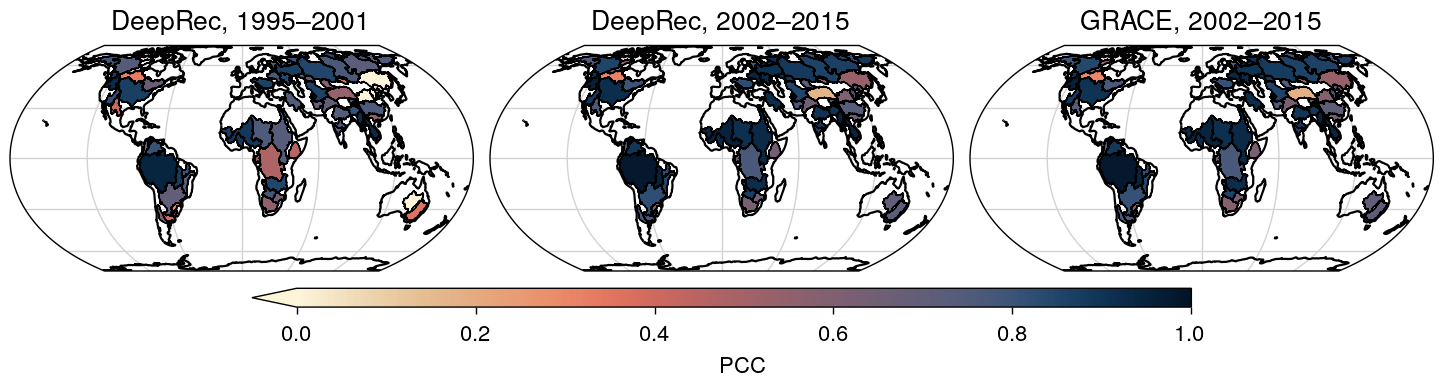

In [31]:
fig, axs = plt.subplots(
    ncols=3, figsize=(7.2, 2.1), subplot_kw={"projection": ccrs.EqualEarth()}
)

# PCC Ours Pre-GRACE
p_pcc = our_pcc_pre.dr.projplot_basins(da_dummy, ax=axs[0], **pcc_kwargs)
axs[0].set(title=f"DeepRec, {period_pre[0]}--{period_pre[1]}")

# PCC Ours GRACE era
our_pcc_post.dr.projplot_basins(da_dummy, ax=axs[1], **pcc_kwargs)
axs[1].set(title=f"DeepRec, {period_post[0]}--{period_post[1]}")

# PCC GRACE
csr_pcc_post.dr.projplot_basins(da_dummy, ax=axs[2], **pcc_kwargs)
axs[2].set(title=f"GRACE, {period_post[0]}--{period_post[1]}")

for ax in axs:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
fig.colorbar(p_pcc, ax=axs, label="PCC", **pcc_cbar_kwargs)


## Boxplots

Weight according to basin size. We achieve this by repeating samples (rows) by an integer number proportional to their basin size.

In [32]:
# Series of basin areas
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

In [33]:
# Convert DataArray to DataFrame
df_pcc = da_pcc.to_dataframe(name="pcc").reset_index()
df_pcc["model_verbose"] = df_pcc["model"].map(vars_verbose)

# Convert area to integer (we define the smallest area as 10)
s_basin_ints = (s_basin_areas / s_basin_areas.min() * 10).round().astype(int)

# Merge with area integers
df_pcc_area = df_pcc.merge(s_basin_ints, left_on="region", right_index=True)

# Create weighted dataframe (columns repeated according to area integers)
df_pcc_weighted = repeat_by_weight(df_pcc_area, "area")


In [34]:
# Order by increasing mean
my_order = (
    df_pcc[df_pcc.era == "pre"]
    .groupby(by=["model_verbose"])["pcc"]
    .mean()
    # Sort GRACE to the beginning
    .sort_values(na_position="first")
    .index
)
my_order


Index(['CSR\n(GRACE)', 'WGHM', 'Li's\nCSR Rec', 'Humphrey's\nGSFC Rec',
       'Palazzoli's\nJPL Rec', 'Yin's\nCSR Rec', 'DeepRec\n(Ours)'],
      dtype='object', name='model_verbose')

In [35]:
# For creating self-explaining text on figure legends
legend_renamer = {
    "era": "Era",
    "pre": f"Pre-GRACE era\n({period_pre[0]}--{period_pre[1]})",
    "post": f"GRACE era\n({period_post[0]}--{period_post[1]})",
}


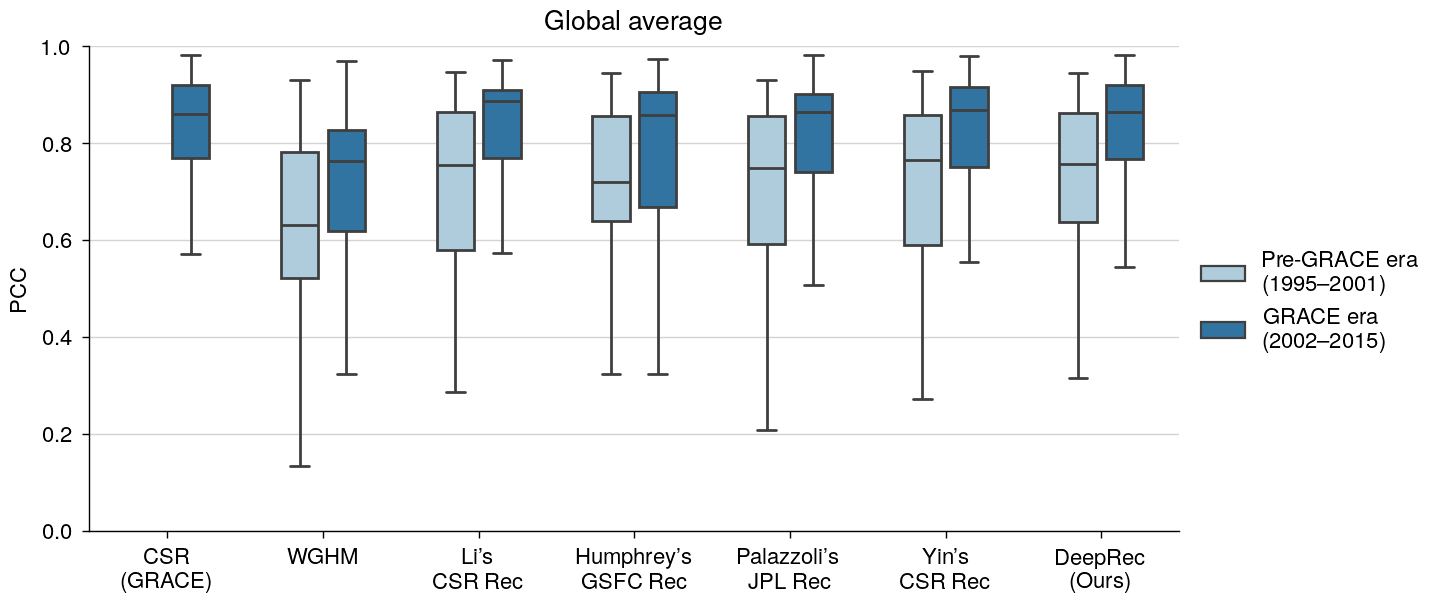

In [36]:
fig, ax = plt.subplots(figsize=(7.2, 3))
sns.boxplot(
    df_pcc_weighted,
    y="pcc",
    x="model_verbose",
    hue="era",
    width=0.6,
    gap=0.2,
    ax=ax,
    order=my_order,
    showfliers=False,
    palette="Paired",
)
ax.set(ylabel="PCC", xlabel=None, ylim=(0, 1), title="Global average")
ax.yaxis.grid()
# Move legend outside of plot
ax.legend().remove()
legend = fig.legend(loc="outside right")
# Replace legend texts
for text in legend.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)

## Combine everything

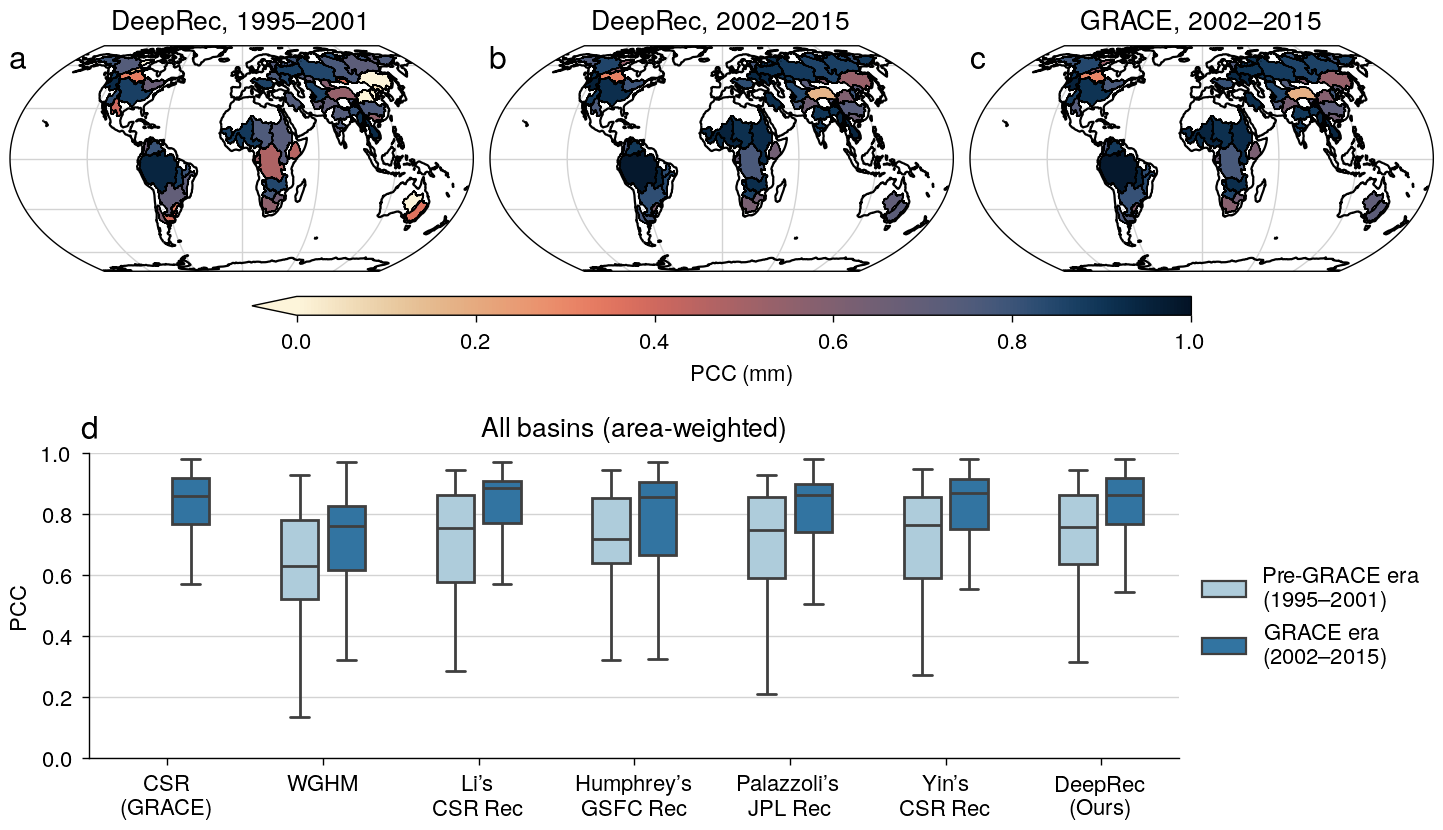

In [37]:
fig = plt.figure(figsize=(7.2, 5))
subfigs = fig.subfigures(nrows=2, hspace=0.03, height_ratios=[4, 3])

axs_geo = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
ax_box = subfigs[1].subplots(1, 1)

### MAP PLOTS ###

# PCC Ours Pre-GRACE
p_pcc = our_pcc_pre.dr.projplot_basins(da_dummy, ax=axs_geo[0], **pcc_kwargs)
axs_geo[0].set(title=f"DeepRec, {period_pre[0]}--{period_pre[1]}")

# PCC Ours GRACE era
our_pcc_post.dr.projplot_basins(da_dummy, ax=axs_geo[1], **pcc_kwargs)
axs_geo[1].set(title=f"DeepRec, {period_post[0]}--{period_post[1]}")

# PCC GRACE
csr_pcc_post.dr.projplot_basins(da_dummy, ax=axs_geo[2], **pcc_kwargs)
axs_geo[2].set(title=f"GRACE, {period_post[0]}--{period_post[1]}")

for ax in axs_geo:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
subfigs[0].colorbar(p_pcc, ax=axs_geo, label="PCC (mm)", **pcc_cbar_kwargs)


### BOXPLOT ###

sns.boxplot(
    df_pcc_weighted,
    y="pcc",
    x="model_verbose",
    hue="era",
    width=0.6,
    gap=0.2,
    ax=ax_box,
    order=my_order,
    showfliers=False,
    palette="Paired",
)

ax_box.set(ylabel="PCC", xlabel=None, ylim=(0, 1), title="All basins (area-weighted)")
ax_box.yaxis.grid()
# Move legend outside of plot
ax_box.legend().remove()
legend = subfigs[1].legend(loc="outside right")
# Replace legend texts
for text in legend.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)


### LETTERS ###

for n, ax in enumerate(axs_geo):
    ax.text(
        0.0,
        1.0 - 0.10,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
ax_box.text(
    0.0,
    1.0 + 0.05,
    string.ascii_lowercase[len(axs_geo)],
    ha="center",
    transform=ax_box.transAxes,
    size="x-large",
    weight="bold",
)

fig.savefig(FIGURE_DIR / "slr_pcc.pdf", backend="pgf")